In [1]:
import base64
import gzip
import io
import pickle
from collections import defaultdict

import albumentations as A
import numpy as np
import plotly.express as px
import timm
import torch
from albumentations.pytorch import ToTensorV2
from dash import dcc, html, Input, Output, no_update
from jupyter_dash import JupyterDash
from PIL import Image
from plotly import graph_objects as go
from plotly import io as pio
from torch import nn
from tqdm.auto import tqdm
from umap import UMAP


from src.constants import DATA_SAMPLE_PATH
from src.utils import load_all_categories, read_image


COLORS = px.colors.qualitative.Plotly
pio.renderers.default = "notebook"

In [2]:
IMAGE_SIZE = 384
OUTPUT_PATH = DATA_SAMPLE_PATH / "embeddings"
OUTPUT_PATH.mkdir(exist_ok=True)

categories_df = load_all_categories(DATA_SAMPLE_PATH)

## prepare data

In [3]:
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, root_path):
        self.root_path = root_path
        self.images_path = self.root_path / "Images" / "image"

        self.metadata = load_all_categories(self.root_path)
        self.transform = A.Compose(
            [
                A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ]
        )

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, ind):
        image_filename = self.metadata.iloc[ind]["image_filename"]
        category = self.metadata.iloc[ind]["category"]

        image = read_image(self.images_path / image_filename)
        image = self.transform(image=image)["image"]

        return image, category

In [4]:
images_ds = ImagesDataset(DATA_SAMPLE_PATH)
images_dl = torch.utils.data.DataLoader(
    images_ds, batch_size=64, shuffle=False, num_workers=8, pin_memory=True
)

## extract embeddings

In [5]:
def extract_embeddings(model, images_dl):
    model.eval()

    all_embeddings = []
    all_categories = []

    for ind, batch in enumerate(tqdm(images_dl)):
        images, categories = batch
        images = images.cuda()

        with torch.no_grad():
            embeddings = model(images)

        all_embeddings.append(embeddings.cpu())
        all_categories.extend(categories)

    all_embeddings = torch.cat(all_embeddings)

    torch.save(all_embeddings, OUTPUT_PATH / "embeddings.pt")
    torch.save(all_categories, OUTPUT_PATH / "categories.pt")

    return all_embeddings, all_categories

In [6]:
if (OUTPUT_PATH / "embeddings.pt").exists():
    embeddings = torch.load(OUTPUT_PATH / "embeddings.pt")
    categories = torch.load(OUTPUT_PATH / "categories.pt")
else:
    model = timm.create_model("convnext_base.fb_in22k_ft_in1k_384", pretrained=True)
    model.head.fc = nn.Identity()

    embeddings, categories = extract_embeddings(model.cuda(), images_dl)

In [7]:
def split_embeddings_by_category(embeddings, categories):
    category_to_embeddings = defaultdict(list)

    for category, embedding in zip(categories, embeddings):
        category_to_embeddings[category].append(embedding)

    for category, embeddings in category_to_embeddings.items():
        category_to_embeddings[category] = np.stack(embeddings)

    return category_to_embeddings

## visualize embeddings

In [8]:
if (OUTPUT_PATH / "reduced_embeddings.pt").exists():
    reduced_embeddings = torch.load(OUTPUT_PATH / "reduced_embeddings.pt")
else:
    reducer = UMAP(random_state=0, metric="cosine")
    reduced_embeddings = reducer.fit_transform(embeddings.numpy())
    reduced_embeddings = split_embeddings_by_category(reduced_embeddings, categories)

    torch.save(reduced_embeddings, OUTPUT_PATH / "reduced_embeddings.pt")

In [9]:
def np_image_to_base64(im_matrix):
    im = Image.fromarray(im_matrix)
    buffer = io.BytesIO()
    im.save(buffer, format="jpeg")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/jpeg;base64, " + encoded_image
    return im_url


def get_image(point_num, category_num, metadata):
    category = list(reduced_embeddings.keys())[category_num]
    category_metadata = metadata[metadata["category"] == category]

    image_filename = category_metadata.iloc[point_num]["image_filename"]
    image = read_image(DATA_SAMPLE_PATH / "Images" / "image" / image_filename)
    likes = category_metadata.iloc[point_num]["#likes"]
    return image, category, likes

In [10]:
def plot_embeddings(*embeddings, labels: list[str]):
    fig = go.Figure()
    for i, embedding in enumerate(embeddings):
        size = 2
        fig.add_trace(
            go.Scatter(
                x=embedding[:, 0],
                y=embedding[:, 1],
                mode="markers",
                marker=dict(color=COLORS[i], size=size),
                name=labels[i],
            )
        )

    fig.update_layout(
        title="Visualization of images embeddings from different categories",
        xaxis_title="x",
        yaxis_title="y",
        height=620,
        width=1100,
        margin=dict(l=0, r=0, b=0, t=50, pad=4),
        legend=dict(
            itemsizing="constant",
        ),
    )
    fig.update_traces(
        hoverinfo="none",
        hovertemplate=None,
    )

    return fig

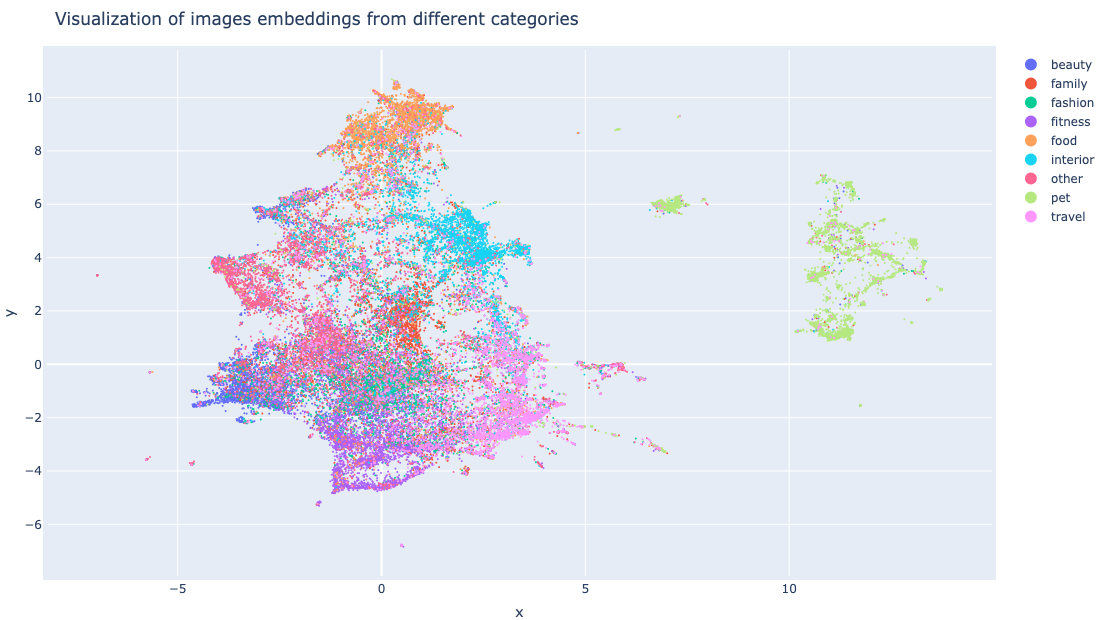

In [11]:
fig = plot_embeddings(
    *reduced_embeddings.values(),
    labels=list(reduced_embeddings.keys()),
)
fig.show(renderer="png")

In [12]:
app = JupyterDash(__name__)

app.layout = html.Div(
    className="container",
    children=[
        dcc.Graph(id="graph-5", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip-5", direction="bottom"),
    ],
)


@app.callback(
    Output("graph-tooltip-5", "show"),
    Output("graph-tooltip-5", "bbox"),
    Output("graph-tooltip-5", "children"),
    Input("graph-5", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    hover_data = hoverData["points"][0]
    category_num = hover_data["curveNumber"]
    bbox = hover_data["bbox"]
    point_num = hover_data["pointNumber"]

    im_matrix, category, likes = get_image(point_num, category_num, categories_df)
    im_url = np_image_to_base64(im_matrix)
    children = [
        html.Div(
            [
                html.Img(
                    src=im_url,
                    style={
                        "width": "192px",
                        "height": "192px",
                        "display": "block",
                        "margin": "0 auto",
                    },
                ),
                html.Span(f"{category} - {likes} likes"),
            ]
        )
    ]

    return True, bbox, children


app.run_server(mode="inline", debug=True)